In [ ]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img, plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization

## Check GPU for tensorflow readiness

In [ ]:
import tensorflow as tf

# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Tensorflow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Check GPU device name
if tf.test.is_gpu_available():
    print("GPU device name:", tf.test.gpu_device_name())

# Check memory usage of GPU
if tf.test.is_gpu_available():
    print("GPU memory:", tf.config.experimental.get_memory_usage('GPU:0'))

# Check if TensorFlow is using GPU for computations
print("TensorFlow is using GPU for computations:", tf.test.is_gpu_available())

# Check the list of available physical devices (GPUs)
print("Available physical devices (GPUs):", tf.config.experimental.list_physical_devices('GPU'))

# !nvidia-smi


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.10.0
Num GPUs Available: 1
GPU device name: /device:GPU:0
GPU memory: 416155392
TensorFlow is using GPU for computations: True
Available physical devices (GPUs): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Manage file paths

In [ ]:
# folder = 'train/yawn/'
# count = 1

# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "1_drowsy_" +str(count)+".jpg"
#     os.rename(source, destination)
#     count+=1
# print("All files are renamed in the yes dir.")

In [ ]:
# folder = 'train/no_yawn/'
# count = 1

# for filename in os.listdir(folder):
#     source = folder + filename
#     destination = folder + "0_notdrowsy_" +str(count)+".jpg"
#     os.rename(source, destination)
#     count+=1
# print("All files are renamed in the yes dir.")

## Load the Dataset

In [ ]:
BASE_DIR_YAWN = r"C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Open Topics\drowsiness detection\DRIVER-DRAWSINESS-PREDICTION\train\drowsy_notdrowsy"
BASE_DIR_YAWN

'C:\\Users\\aekas\\Desktop\\Year 3\\Term 2\\FRA361 Open Topics\\drowsiness detection\\DRIVER-DRAWSINESS-PREDICTION\\train\\drowsy_notdrowsy'

## Exploratory Data Analysis

In [ ]:
image_paths = []
status_labels = []

for filename in tqdm(os.listdir(BASE_DIR_YAWN)):
    image_path = os.path.join(BASE_DIR_YAWN, filename)
    temp = filename.split('_', 1)
    status = int(temp[0])
    image_paths.append(image_path)
    status_labels.append(status)

  0%|          | 0/1448 [00:00<?, ?it/s]

In [ ]:
image_paths = np.array(image_paths)
status_labels = np.array(status_labels)
print("Total images:", len(image_paths))
print("Total labels:", len(status_labels))

Total images: 1448
Total labels: 1448


In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['status'] = image_paths, status_labels
df.head()

,image,status
0,C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...,0
1,C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...,0
2,C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...,0
3,C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...,0
4,C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Op...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1448 non-null   object
 1   status  1448 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 17.1+ KB


<Axes: xlabel='status', ylabel='Density'>

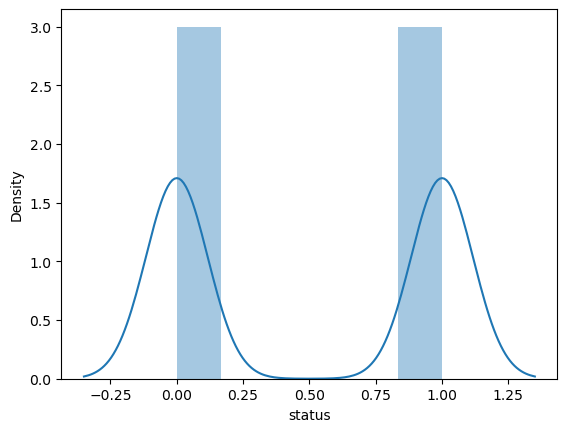

In [ ]:
sns.distplot(df['status'])

In [ ]:
df['status'].describe()

count    1448.000000
mean        0.500000
std         0.500173
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: status, dtype: float64

In [ ]:
# map labels for status
status_dict = {0:'Non drowsy', 1:'Drowsy'}

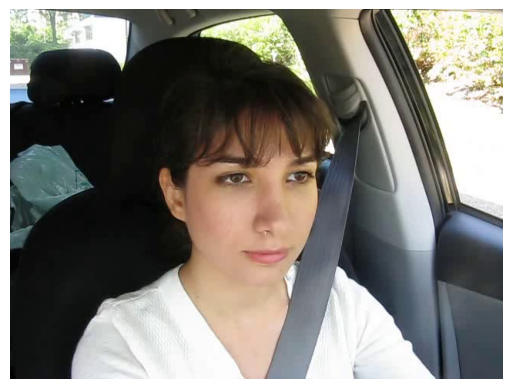

Image shape: (640, 480)


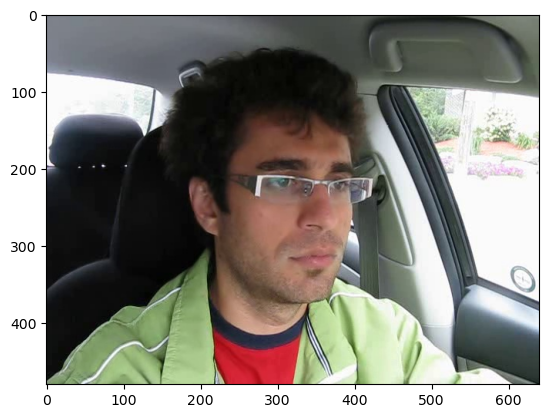

In [ ]:
from PIL import Image
import random

# Get a random index within the range of your dataset
random_index = random.randint(0, len(df) - 1)

# Get the image path at the random index
random_image_path = df.iloc[random_index]['image']

# Load the random image
img = Image.open(random_image_path)

# Display the random image
plt.axis('off')
plt.imshow(img)
plt.show()

print("Image shape:", load_img(image_paths[0]).size)
plt.imshow(plt.imread(r"C:\Users\aekas\Desktop\Year 3\Term 2\FRA361 Open Topics\drowsiness detection\DRIVER-DRAWSINESS-PREDICTION\train\drowsy_notdrowsy\0_notdrowsy_9.jpg"))

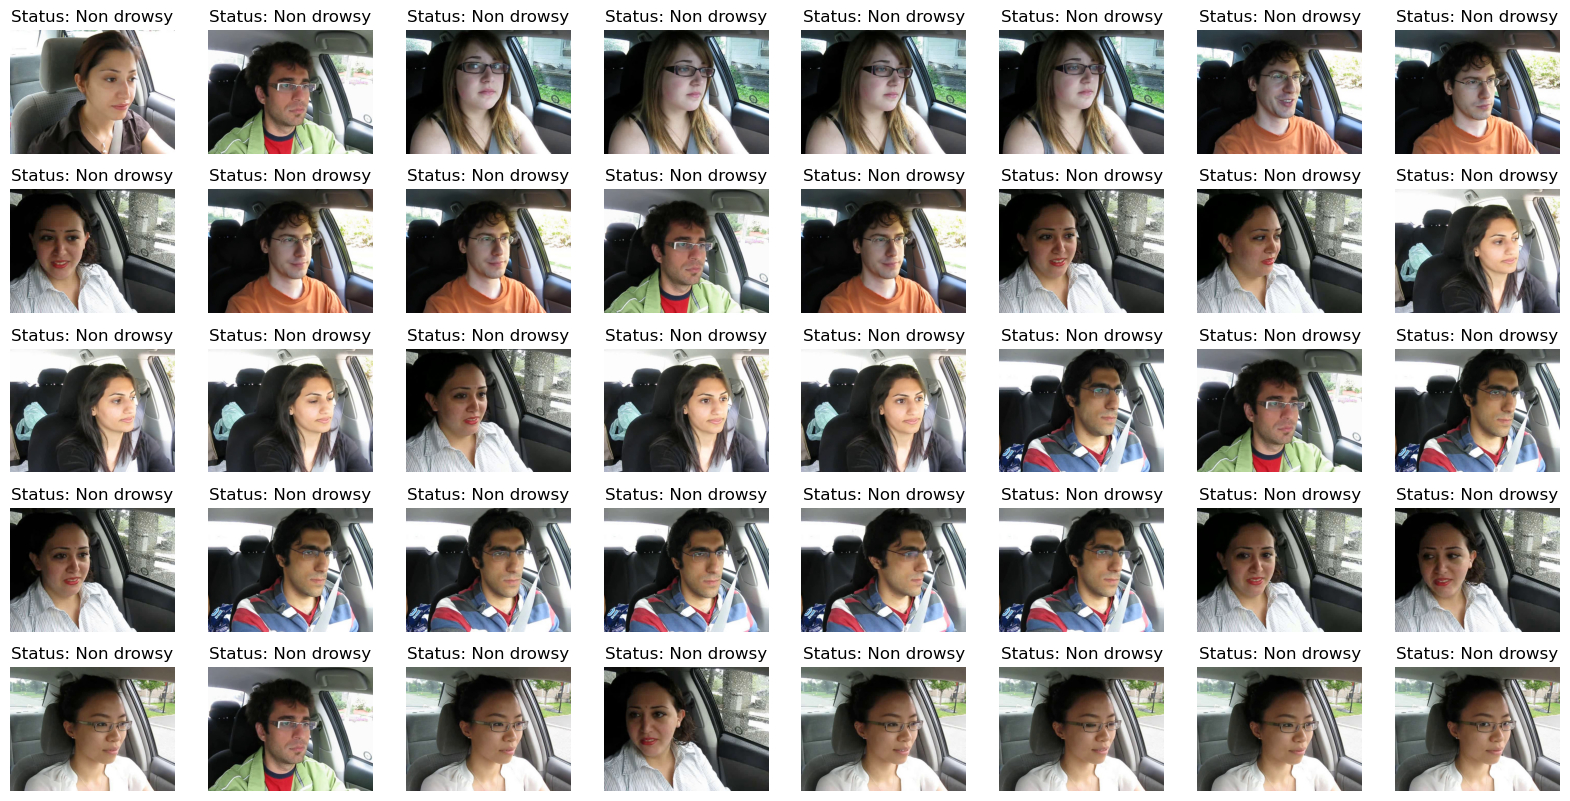

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 10))
files = df.iloc[0:40]

for index, file, status in files.itertuples():
    plt.subplot(5, 8, index+1)
    img = load_img(file)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(f"Status: {status_dict[status]}")
    plt.axis('off')

## Feature Extraction

  0%|          | 0/1 [00:00<?, ?it/s]

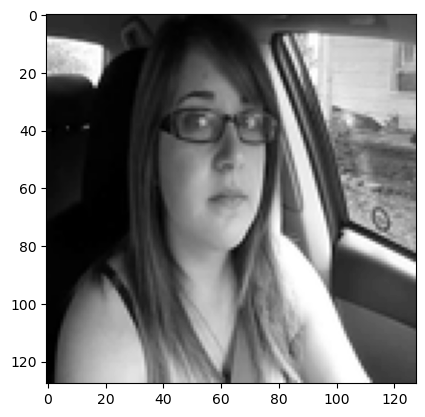

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)  
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features
plt.imshow(extract_features([image_paths[2]])[0].reshape(128, 128), cmap='gray')

In [ ]:
X = extract_features(df['image'])
X.shape

  0%|          | 0/1448 [00:00<?, ?it/s]

(1448, 128, 128, 1)

In [ ]:
y_status = np.array(df['status'])
print("X shape:", X.shape)
print("y shape:", y_status.shape)

X shape: (1448, 128, 128, 1)
y shape: (1448,)


## Model Creation

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_status, test_size=0.2, random_state=42)

# Normalize the training and testing data
X_train = X_train / 255.0
X_test = X_test / 255.0

model = tf.keras.models.Sequential()
# Convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(128, 128 ,1), activation='relu', padding='same')),
model.add(MaxPooling2D(pool_size=(2, 2))),

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(MaxPooling2D(pool_size=(2, 2))),

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(MaxPooling2D(pool_size=(2, 2))),

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')),
model.add(MaxPooling2D(pool_size=(2, 2))),

model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid', name='drowsiness_output'))

# Compile the model
print("Compiling the model...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy  ,
              metrics=['accuracy'])

# Train the model on the training data
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=60, validation_data=(X_test, y_test))


Compiling the model...
Epoch 1/60
37/37 [==============================] - 1s 27ms/step - loss: 0.7101 - accuracy: 0.5544 - val_loss: 0.6806 - val_accuracy: 0.5966
Epoch 2/60
37/37 [==============================] - 1s 23ms/step - loss: 0.6043 - accuracy: 0.6252 - val_loss: 0.6225 - val_accuracy: 0.6103
Epoch 3/60
37/37 [==============================] - 1s 23ms/step - loss: 0.5696 - accuracy: 0.6753 - val_loss: 0.5981 - val_accuracy: 0.6586
Epoch 4/60
37/37 [==============================] - 1s 22ms/step - loss: 0.5485 - accuracy: 0.6900 - val_loss: 0.5807 - val_accuracy: 0.6793
Epoch 5/60
37/37 [==============================] - 1s 22ms/step - loss: 0.5142 - accuracy: 0.7288 - val_loss: 0.5737 - val_accuracy: 0.6897
Epoch 6/60
37/37 [==============================] - 1s 23ms/step - loss: 0.4876 - accuracy: 0.7375 - val_loss: 0.5236 - val_accuracy: 0.7345
Epoch 7/60
37/37 [==============================] - 1s 23ms/step - loss: 0.4563 - accuracy: 0.7884 - val_loss: 0.4763 - val_accurac

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) 

(1158, 128, 128, 1) (1158,)
(290, 128, 128, 1) (290,)


In [ ]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_222 (Conv2D)         (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_220 (MaxPooli  (None, 64, 64, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_223 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_221 (MaxPooli  (None, 32, 32, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_224 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_222 (MaxPooli  (None, 16, 16, 128)    

In [ ]:
# Evaluate the model on the testing data (optional)
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9828
Test Loss: 0.05042583867907524
Test Accuracy: 0.982758641242981


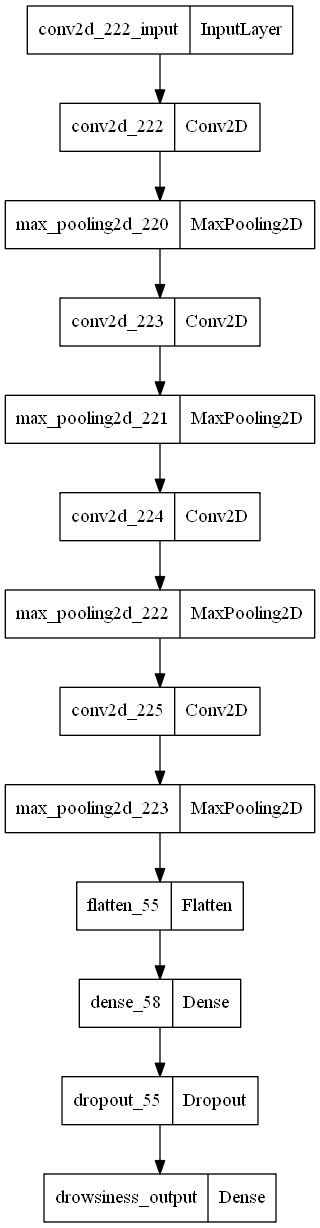

In [ ]:
# # Plot the model architecture
plot_model(model)

## Plot the Results

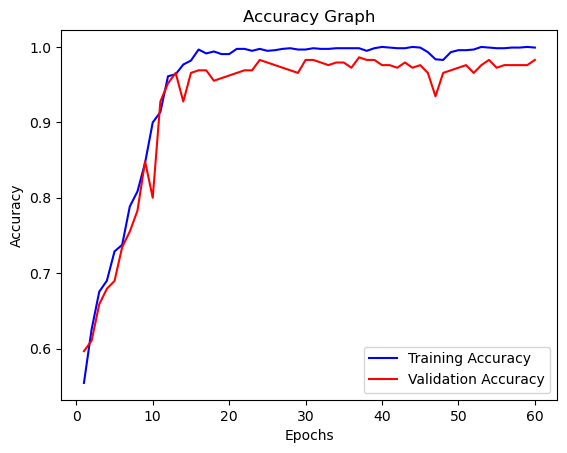

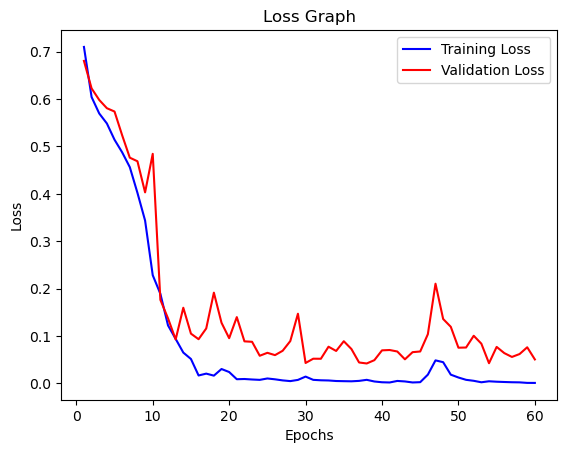

In [ ]:
# Plot results for accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot results for loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Classification report

In [ ]:
from sklearn.metrics import classification_report
# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.round(predictions).reshape(-1)

# Convert numeric labels to class names
class_names = [status_dict[i] for i in range(len(status_dict))]

# Generate classification report
print(classification_report(y_test, predicted_classes, target_names=class_names))

10/10 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

  Non drowsy       0.98      0.99      0.98       139
      Drowsy       0.99      0.98      0.98       151

    accuracy                           0.98       290
   macro avg       0.98      0.98      0.98       290
weighted avg       0.98      0.98      0.98       290



## Prediction with Test Data

Original Status: Non drowsy
1/1 [==============================] - 0s 65ms/step
Predicted Status: Non drowsy


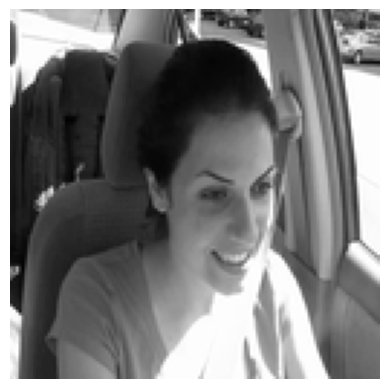

In [ ]:
image_index = 190
print("Original Status:", status_dict[y_status[image_index]])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_status = status_dict[round(pred[0][0])]
print("Predicted Status:", pred_status)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Status: Non drowsy
1/1 [==============================] - 0s 16ms/step
Predicted Status: Non drowsy


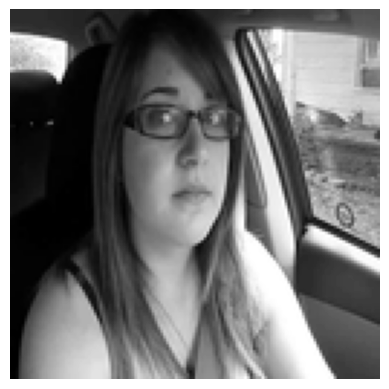

In [ ]:
image_index = 2
print("Original Status:", status_dict[y_status[image_index]])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_status = status_dict[round(pred[0][0])]
print("Predicted Status:", pred_status)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Status: Drowsy
1/1 [==============================] - 0s 16ms/step
Predicted Status: Drowsy


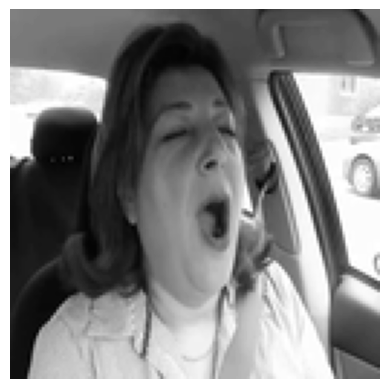

In [ ]:
image_index = 820
print("Original Status:", status_dict[y_status[image_index]])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_status = status_dict[round(pred[0][0])]
print("Predicted Status:", pred_status)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');